## Original Notebook classifying all 4 classes:
- 0 : Glioma Tumor
- 1 : Meningioma Tumor
- 2 : No Tumor
- 3 : Pituitary Tumor

In [1]:
import sys
sys.path.append('../src/')
sys.path.append('../tests/')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import os
import shutil
import imghdr
import random
import mlflow
import dagshub
import Data_Augmentation
import Data_Loader
import Plotting_functions
import Model_Builder
import Data_Cleaning
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

from Data_Loader import DataLoader
from Data_Augmentation import Data_Augmentation
from Data_Cleaning import Cleaner
from Plotting_functions import Plotting_functions
from Model_Builder import CNNModel


2024-10-29 12:50:21.171007: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Source: [Brain Tumor Classification (MRI)](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)

In [3]:
#Initialise class
data_loader = DataLoader()
Augmentator = Data_Augmentation()
ModelBuilder = CNNModel()
Cleaning = Cleaner(ModelBuilder)


In [4]:
training_path = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Images_Brain/Training'
testing_path = '/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Images_Brain/Testing'

In [5]:
# Checking to see the different folders within our path
for image_class in os.listdir(training_path):
  print(image_class)


no_tumor
meningioma_tumor
glioma_tumor
pituitary_tumor


In [6]:
img = cv2.imread(os.path.join(training_path, 'pituitary_tumor', 'p (503).jpg'))
img.shape # We can see the image is a 512x512 with a depth of 3

(512, 512, 3)

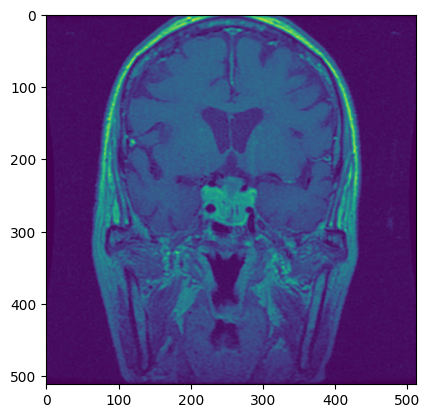

In [7]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY ))
plt.show()

# Loading data

The datset was already split into testing and training data so we do not need to define these later

In [8]:
# Load the training dataset
Training_data = data_loader.Load_Training_data(training_path)
# Load the validation dataset
Validation_data = data_loader.Load_Validaion_data(training_path)
# Load the testing dataset
Testing_data = data_loader.Load_Testing_data(testing_path)

Found 2870 files belonging to 4 classes.
Using 2296 files for training.
Found 2870 files belonging to 4 classes.
Using 574 files for validation.
Found 394 files belonging to 4 classes.


In [9]:
# Ensuring that the data is of the correct structure
data_loader.validate_data(Training_data)
data_loader.validate_data(Validation_data)
data_loader.validate_data(Testing_data)

2024-10-29 12:50:36.453928: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-29 12:50:37.025811: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-29 12:50:37.330758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [10]:
Training_iterator = Training_data.as_numpy_iterator()
Testing_iterator = Testing_data.as_numpy_iterator()
batch_training = Training_iterator.next()

# Inspect class names
class_names = Training_data.class_names
print("Class Names:", class_names)

#Initialisng Plotting functions class using our labels
Plotter = Plotting_functions(class_names, labels_testing=None) # Error checker in Plotting_functions to ensure class labels has correct format

Class Names: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [11]:
len(Testing_iterator.next()[1])

32

In [12]:
print(batch_training[0].shape) # Images are now of dimension 256 x 256 x 3 which is wha we want, we have 32 images in this batch
print(batch_training[1]) # Labels are 0,1,2 and 3 for the different classes

(32, 256, 256, 1)
[2 3 0 3 1 0 2 1 2 0 3 1 1 2 1 0 2 3 1 0 1 2 3 0 2 0 3 0 0 0 1 3]


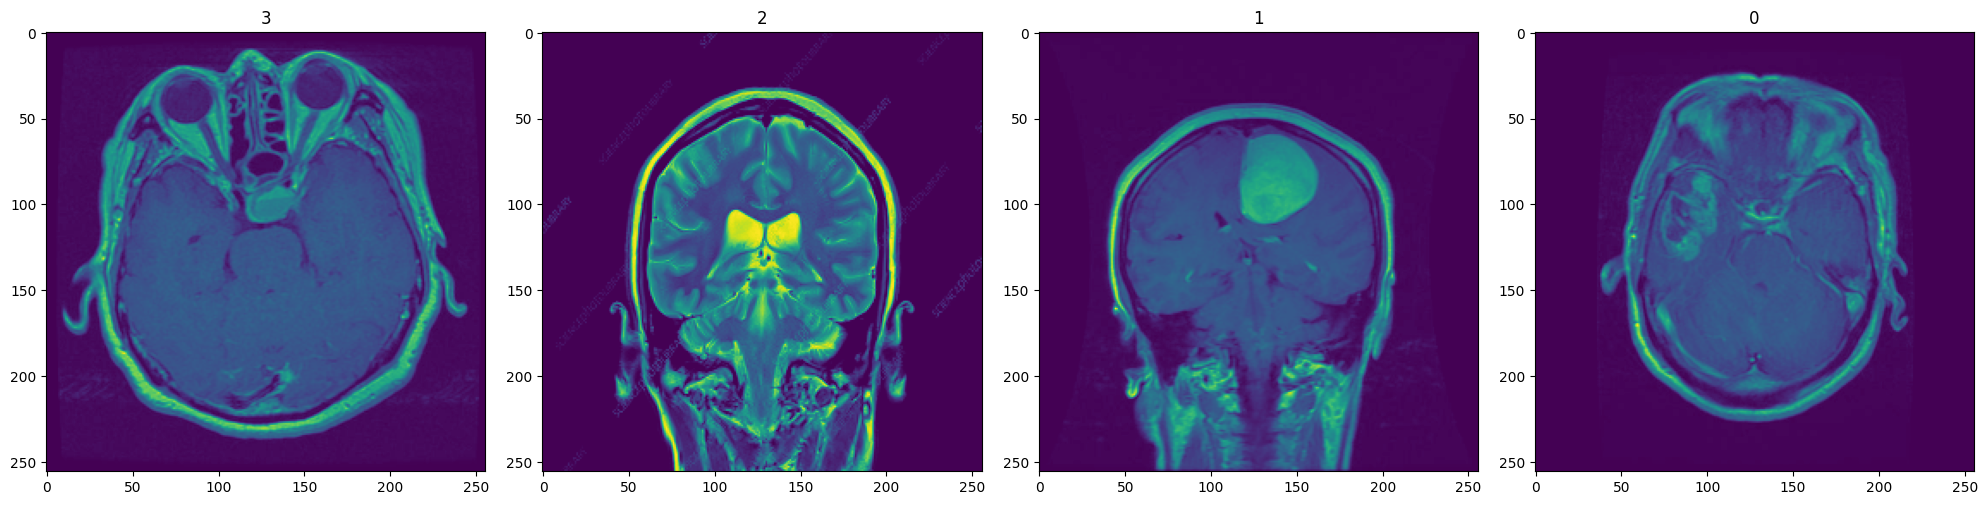

In [13]:
Plotter.plot_tumour(batch_training) # Batch training derived from Training_data which gets checked as inputted, so this is also error free

#### Labels
-   0 : Glioma Tumor
-   1 : Meningioma Tumor
-   2 : No Tumor
-   3 : Pituitary Tumor


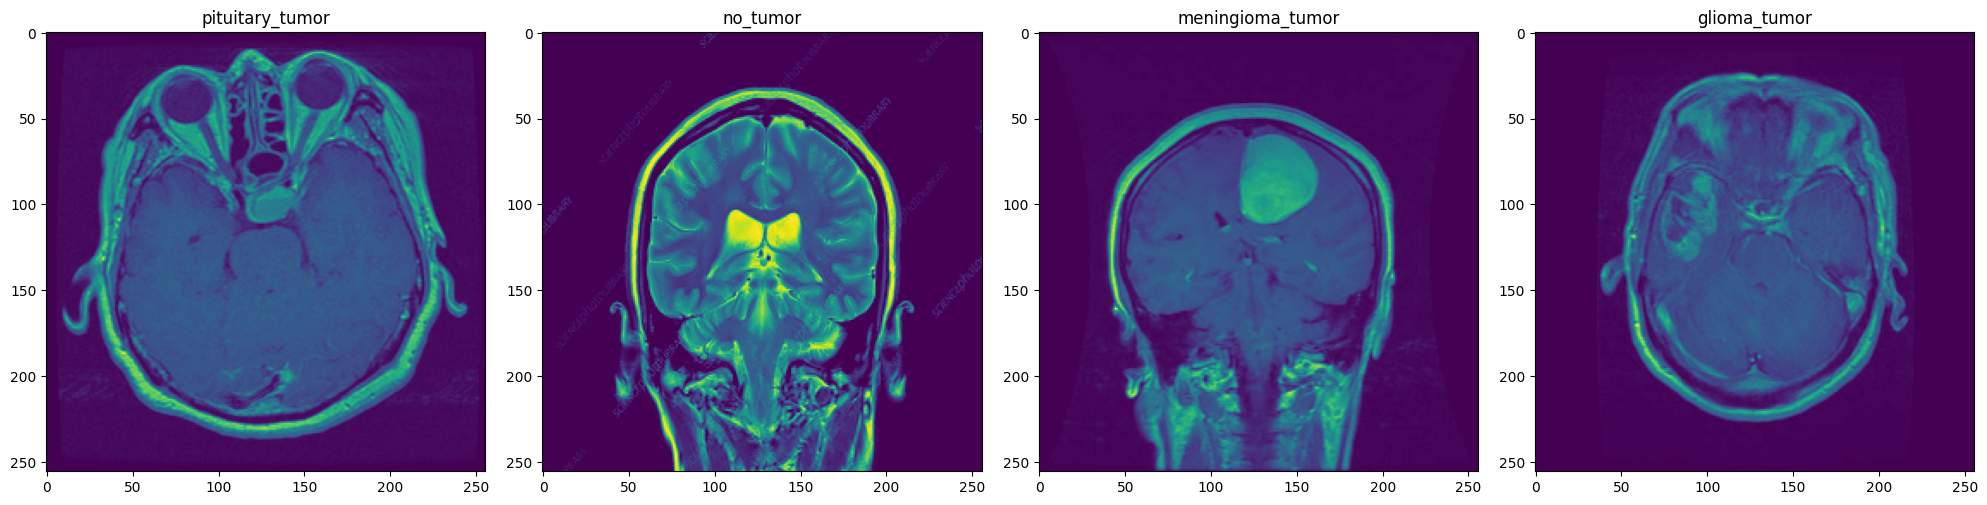

In [14]:
labels = [class_names[label] for label in batch_training[1]]

# Similar plot to earlier but now we have passed through our labels
Plotter.plot_tumour(batch_training, labels)

# Preprocessing Data

In [15]:
num_classes = 4

# Load the training dataset
Training_data = Training_data.map(Augmentator.augment_image)
Training_data = Training_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the validation dataset
Validation_data = Validation_data.map(Augmentator.augment_image)
Validation_data = Validation_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# Load the testing dataset
Testing_data = Testing_data.map(lambda x, y: (x / 255.0, tf.one_hot(y, num_classes)))

# X is Images
# Y is Labels


In [16]:
# Ensuring that the data is of the correct structure after augmentation and before model building
data_loader.validate_data_float(Training_data)
data_loader.validate_data_float(Validation_data)
data_loader.validate_data_float(Testing_data)

2024-10-29 12:50:43.051403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-29 12:50:43.532389: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-29 12:50:43.937512: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


<_MapDataset element_spec=(TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [17]:
# setting up MLflow in Dagshub 

dagshub.init(repo_owner='HarjitG', repo_name='Brain-Tumour-Classification', mlflow=True)

Accessing as HarjitG

Initialized MLflow to track repo "HarjitG/Brain-Tumour-Classification"

Repository HarjitG/Brain-Tumour-Classification initialized!

In [18]:
# Setting tracking URI to MLflow served hosted on dagshub
mlflow.set_tracking_uri("https://dagshub.com/HarjitG/Brain-Tumour-Classification.mlflow")

# Deep Model

In [19]:
logdir = "/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Notebooks/logs"

# Build the model with custom hyperparameters
ModelBuilder.build_model() 

# Compile the model
ModelBuilder.compile()


ModelBuilder.summary()

# Train the model
hist = ModelBuilder.train(
    Training_data=Training_data,
    Validation_data=Validation_data,
    epochs=20,
    log_dir=logdir,
)

/Users/harjitgakhal/.local/share/virtualenvs/Brain-Tumour-Classification-Lpua87O-/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model compiled successfully


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 16)   │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,731,572 (14.23 MB)

 Trainable params: 3,731,572 (14.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 75s 996ms/step - accuracy: 0.4393 - loss: 2.6928 - val_accuracy: 0.5819 - val_loss: 1.6975
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 63s 865ms/step - accuracy: 0.5579 - loss: 1.5864 - val_accuracy: 0.6725 - val_loss: 1.2537
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 921ms/step - accuracy: 0.6631 - loss: 1.2075 - val_accuracy: 0.5836 - val_loss: 1.3695
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.6712 - loss: 1.2160 - val_accuracy: 0.7491 - val_loss: 0.9648
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 69s 955ms/step - accuracy: 0.7454 - loss: 0.9363 - val_accuracy: 0.7056 - val_loss: 0.9182
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.8016 - loss: 0.8242 - val_accuracy: 0.6707 - val_loss: 1.0110
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 67s 926ms/step - accuracy: 0.8160 - loss: 0.8038 - val_accuracy: 0.7892 - val_loss: 0.7945
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 62s 859ms/step - accuracy: 0.8561 - loss: 0.6938 - val_accuracy: 

In [20]:
print(list(hist.history))

['accuracy', 'loss', 'val_accuracy', 'val_loss']


## Model Evaluation

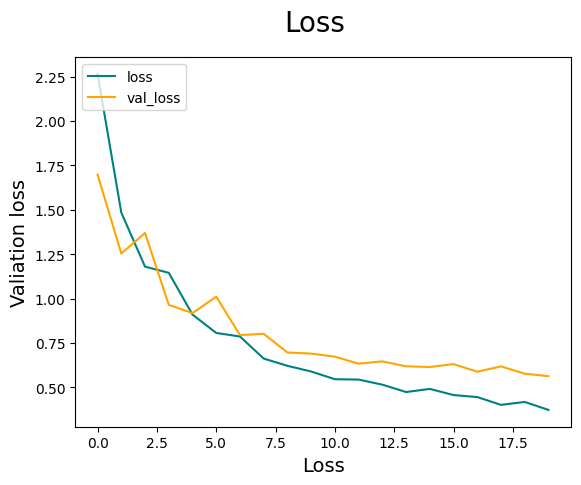

In [38]:
Plotter = Plotting_functions(class_names)

Plotter.plot_loss(hist)

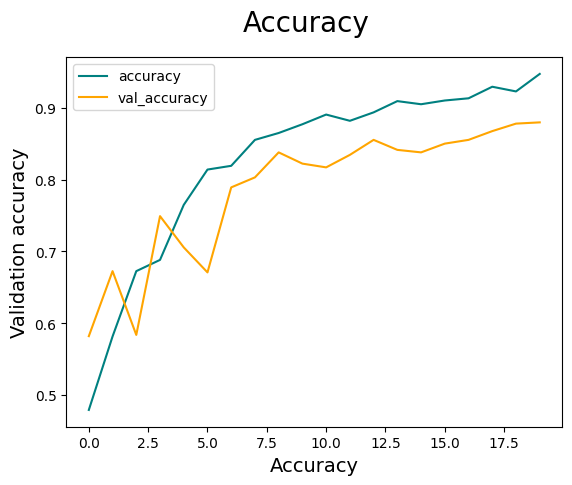

In [24]:
Plotter.plot_accuracy(hist)

## Testing data

In [26]:
X_test, labels_testing = Cleaning.Testing_data_cleaner(Testing_data)

2024-10-29 13:20:20.051876: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [29]:
y_, yhat_binary, pre, re, acc = Cleaning.y_predictor(
    X_test=X_test, labels_testing=labels_testing
)

13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 239ms/step
Precision: 0.7786666750907898
Recall: 0.9931972622871399
Accuracy: 0.3350253701210022


In [31]:
# Logging our results to MLFlow
mlflow.log_metric("Precision", pre.result().numpy())
mlflow.log_metric("Recall", re.result().numpy())
mlflow.log_metric("Accuracy", acc.result().numpy())

## Conclusion

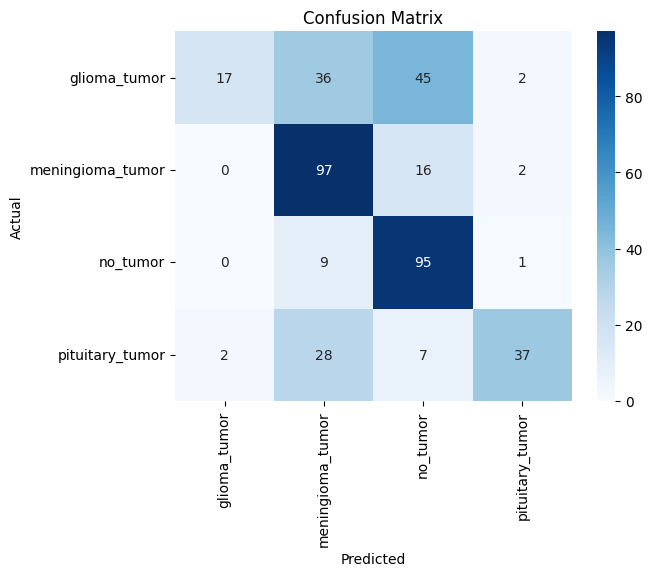

In [35]:
Plotter = Plotting_functions(class_names, labels_testing)
Plotter.plot_confusion_matrix(y_, yhat_binary)

We can say that while Meningioma, Pituitary, and No tumor are being picked up well, Glioma tumor however isn't so easily and is something that would require future work

## Saving model

In [36]:
# ModelBuilder.model.save('/Users/harjitgakhal/Documents/Github_Repositories/Brain-Tumour-Classification/Model.h5')